# DeepFM
<font color = "blue">**算法思想**</font> ：为了同时学习高阶和低阶的组合特征，Deep FM集成了因子分解机（FM）和深度神经网络（DNN）的体系结构。FM算法负责对一阶特征以及二阶特征（由一阶特征交叉组合得到的）进行特征的提取；DNN算法负责对高阶特征进行特征的提取。   

In [95]:
import numpy as np
from keras.layers import *
from keras.models import Model
from keras import backend as K
from keras import optimizers
from keras.engine.topology import Layer
import matplotlib.pyplot as plt

## 模拟数据

In [96]:
# 样本和标签，这里需要对应自己的样本做处理
train_x = [
    np.array([0.5, 0.7, 0.9]),
    np.array([2, 4, 6]),
    np.array([[0, 1, 0, 0, 0, 1, 0, 1], [0, 1, 0, 0, 0, 1, 0, 1],
              [0, 1, 0, 0, 0, 1, 0, 1]])
]
label = np.array([0, 1, 0])

## 定义模型
![](./imgs/DeepFM.png)

### 输入定义
数据格式说明
- 单值离散特征而是直接输入index

- 多值离散特征也是输入 index，但是是输入一串对应的 index 值，如 [5,9,11]

- 如果有没有维表的字符串特征，我们通过哈希转换成某个范围内的数字，这个转换是确定的，比如 “hello” 恒转换成 10，即变成了 1 情况里描述的单值离散特征 （哈希是会出现一定概率碰撞的，这里需要将维度冗余大约10倍使碰撞率低于5%，目前这样处理在我们的场景下模型效果无差异）

- 连续值直接输入即可。（如果是较大的连续值，需在特征工程部分先做归一化，或者考虑先做离散化处理成离散值）

In [47]:
continuous = Input(shape=(1, ), name="single_continuous")
single_discrete = Input(shape=(1, ), name="single_discrete")
multi_discrete = Input(shape=(8, ), name="multi_discrete")

### FM部分
![](./imgs/FM1.png)
#### FM一阶部分构造
一阶运算公式：
$$first\_order\_sum = \sum_{i=0}^n{w_i*x_i}$$
特征图解:  
![](./imgs/one-order.png)

In [49]:
# 特征处理
continuous_dense = Dense(1)(continuous)  # 连续特征
single_embedding = Reshape([1])(
    Embedding(10, 1)(single_discrete))  # single ont-hot
multi_dense = Dense(1)(multi_discrete)

In [50]:
# 一阶项构造
first_order_sum = Add()([continuous_dense, single_embedding, multi_dense])

#### FM 二阶部分构造
二阶运算公式：
$$
second\_order\_sum = 0.5*\sum_{l=1}^{k}[(\sum_{i=1}^nv_{il}x_{i})^2 - \sum_{i=1}^nv_{il}^2x_{i}^2]
$$
特征图解:  
![](./imgs/two-order.png)

In [51]:
continuous_k = Dense(3)(continuous)
single_k = Reshape([3])(Embedding(10, 3)(single_discrete))
multi_k = Dense(3)(multi_discrete)

In [55]:
# 先加和
sum_square_layer = Lambda(
    lambda x: x**2)(Add()([continuous_k, single_k, multi_k]))

In [58]:
# 先平方
continuous_square = Lambda(lambda x: x**2)(continuous_k)
single_square = Lambda(lambda x: x**2)(single_k)
multi_square = Lambda(lambda x: x**2)(multi_k)
square_sum_layer = Add()([continuous_square, single_square, multi_square])

In [62]:
substract_layer = Lambda(lambda x: x**0.5)(Subtract()
                                           ([sum_square_layer, square_sum_layer]))

In [64]:
# 定义求和层
class SumLayer(Layer):

    def __init__(self, **kwargs):
        super(SumLayer, self).__init__(**kwargs)

    def call(self, inputs):
        inputs = K.expand_dims(inputs)
        return K.sum(inputs, axis=1)

    def compute_output_shape(self, input_shape):
        return tuple([input_shape[0], 1])

In [64]:
# 二次项求和
second_order_sum = SumLayer()(substract_layer)
# FM 部分输出
fm_output = Add()([first_order_sum, second_order_sum])

### Deep部分构造
**共享Embedding设计**：在FM部分中，Dense Embedding是为了计算二阶交叉特征信息，但在DNN部分，Dense Embedding是为更高阶的特征交叉信息提供输入（通常认为DNN能够学习高阶特征组合信息）。所以，Dense Embedding同时编码了低阶组合特征与高阶组合特征所需要的信息，作者认为这种方式更有利于模型性能的提升。并且这种共享参数的方式，不需要额外的特征工程，节省了模型构建时间。 

In [79]:
# 共享Embedding
deep_input = Concatenate()([continuous_k, single_k, multi_k])
# DNN架构为：constant类型
deep_layer_0 = Dropout(0.5)(Dense(64, activation='relu')(deep_input))
deep_layer_1 = Dropout(0.5)(Dense(64, activation='relu')(deep_layer_0))
deep_layer_2 = Dropout(0.5)(Dense(64, activation='relu')(deep_layer_1))
deep_output = Dropout(0.5)(Dense(1, activation='relu')(deep_layer_2))

In [71]:
concat_layer = concatenate([fm_output, deep_output])
y = Dense(1, activation="sigmoid")(concat_layer)

## 训练

In [72]:
model = Model(inputs=[continuous, single_discrete, multi_discrete], outputs=y)
Opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999,
                      epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer=Opt, metrics=['acc'])
history = model.fit(train_x, label, shuffle=True, epochs=10,
          verbose=1, batch_size=1024, validation_split=None)

In [90]:
history.history

{'loss': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
 'acc': [0.6666666865348816,
  0.6666666865348816,
  0.6666666865348816,
  0.6666666865348816,
  0.6666666865348816,
  0.6666666865348816,
  0.6666666865348816,
  0.6666666865348816,
  0.6666666865348816,
  0.6666666865348816]}

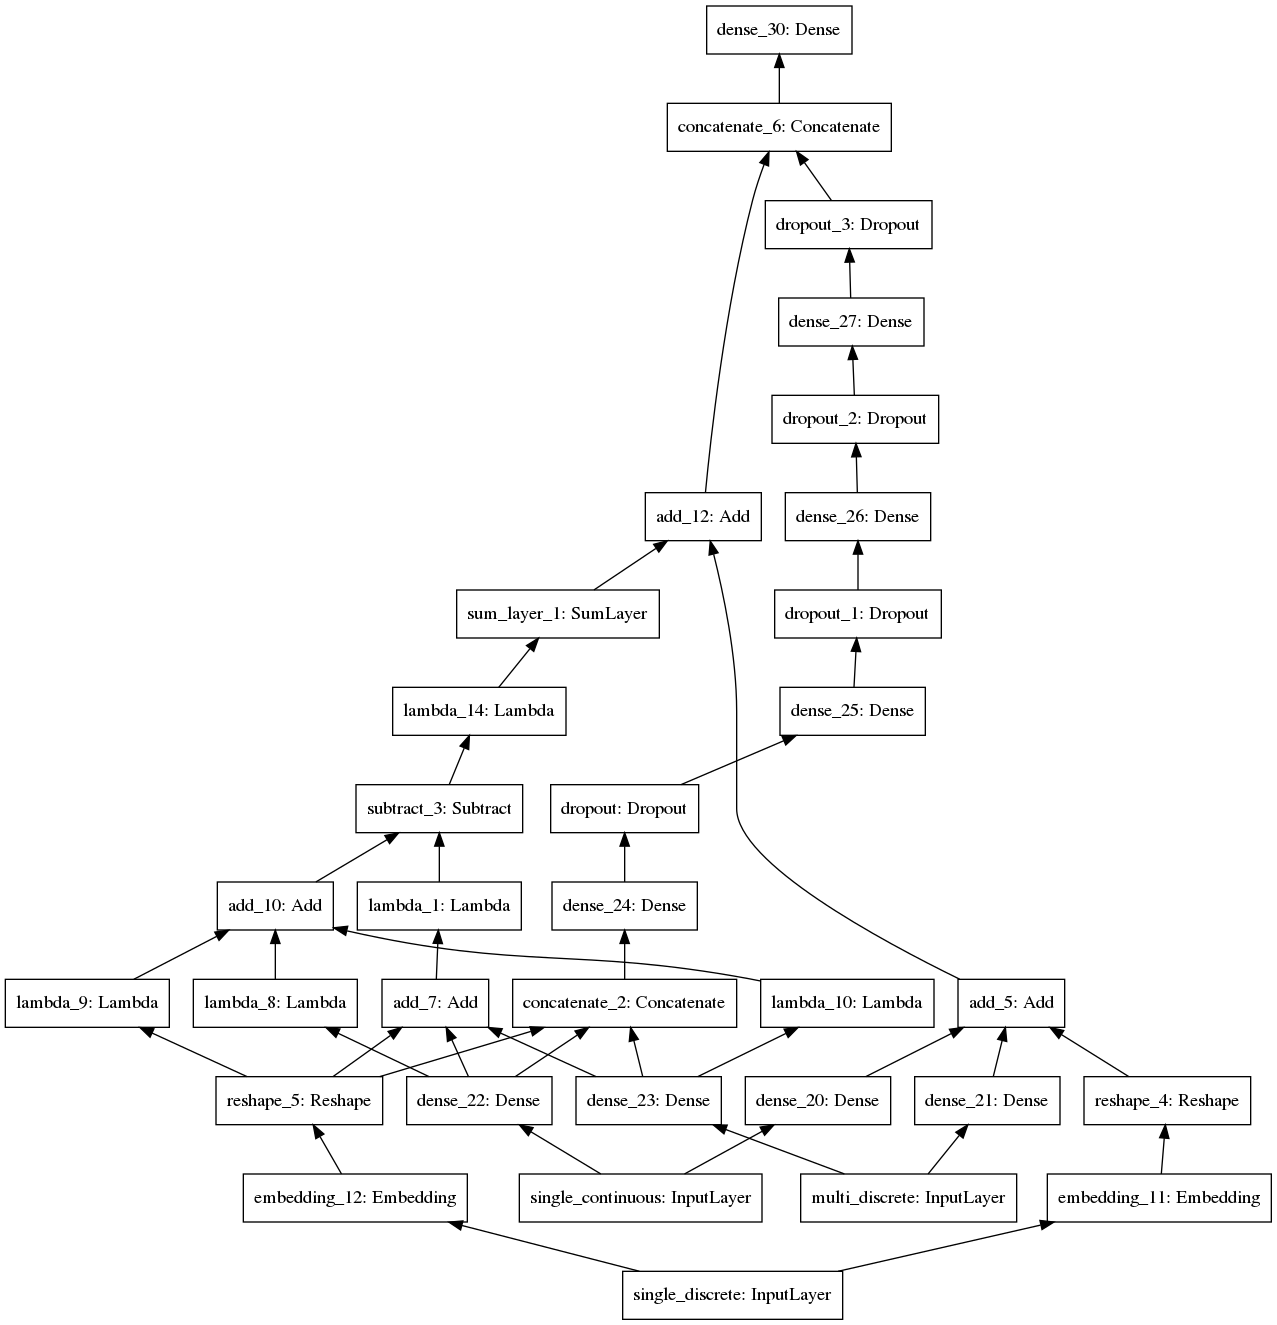

In [93]:
from keras.utils import plot_model
plot_model(model, to_file='./imgs/model.png', rankdir="BT")

## 参考
[用Keras实现一个DeepFM](https://blog.csdn.net/songbinxu/article/details/80151814#t4)  

In [ ]:
multi_one_hot = Embedding(10, 5)(np.array([1, 5]))
mean(multi_one_hot)

NameError: name 'mean' is not defined

In [115]:
from keras import backend as K
from keras.engine.topology import Layer
import tensorflow as tf

class MyMeanPool(Layer):
    def __init__(self, axis, **kwargs):
        self.supports_masking = True
        self.axis = axis
        super(MyMeanPool, self).__init__(**kwargs)

    def compute_mask(self, input, input_mask=None):
        # need not to pass the mask to next layers
        return None

    def call(self, x, mask=None):
        if mask is not None:
            if K.ndim(x)!=K.ndim(mask):
                mask = K.repeat(mask, x.shape[-1])
                mask = tf.transpose(mask, [0,2,1])
            mask = K.cast(mask, K.floatx())
            x = x * mask
            return K.sum(x, axis=self.axis) / K.sum(mask, axis=self.axis)
        else:
            return K.mean(x, axis=self.axis)

    def compute_output_shape(self, input_shape):
        output_shape = []
        for i in range(len(input_shape)):
            if i!=self.axis:
                output_shape.append(input_shape[i])
        return tuple(output_shape)

In [118]:
(MyMeanPool(axis=0)(multi_one_hot))

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 0.02986066,  0.03983549,  0.00385479,  0.02533727, -0.01718153],
      dtype=float32)>